# EDA van audio-CSV bestanden 

**Cell-overzicht (kort)**

1. Titel: korte titel van dit notebook.

2. Imports: laadt `numpy`, `pandas`, `matplotlib` en `seaborn` en zet visuele stijl; vereist voor alle plots en data-manipulatie.

3. Data-locatie: definieert `DATA_DIR` en zoekt alle CSV-bestanden in `Data/` (laat zien welke bestanden worden gebruikt).

4. Functies: `load_csv_hits()` en `print_basic_stats()` — verwerkt CSV-formaten naar per-hit arrays (vorm: n_hits × n_samples) en print samenvattingen (aantal hits, samples per hit, amplitude-statistieken, per-hit RMS).

5. Laden & samenvatting: laadt alle CSV's met `load_csv_hits()`, bewaart ze in `data` en bouwt een snel overzichtstabel (`file`, `n_hits`, `n_samples`).

6. Waveforms: toont overlay van de eerste n hits per bestand plus de gemiddelde golfvorm met ±1 std (handig om variatie en alignement te zien).

7. Amplitude-distributies: per-bestand KDE's en gecombineerde histogrammen — geeft inzicht in amplitudeverdeling en mogelijke clipping/noise.

8. FFT: gemiddelde magnitude-spectrum over hits (log-scale) — helpt bij het identificeren van dominante frequentiebanden karakteristiek voor materiaal of impact.

9. RMS-analyse: per-hit RMS-distributie en rolling-RMS voorbeeld voor een hit — handig om energieverschillen tussen slagen te visualiseren.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set(style="whitegrid")
%matplotlib inline

In [3]:
DATA_DIR = Path('Data')
files = list(DATA_DIR.glob('*.csv'))
files

[WindowsPath('Data/blik.csv'),
 WindowsPath('Data/Book.csv'),
 WindowsPath('Data/hammer.csv'),
 WindowsPath('Data/metalen_pot.csv'),
 WindowsPath('Data/steen.csv'),
 WindowsPath('Data/wood.csv')]

In [6]:
def load_csv_hits(path, expected_len=4800):
    """Load CSV and return hits as a 2D numpy array: (n_hits, n_samples).
    Handles rows-as-hits, single-row CSVs, or single-column continuous samples.
    """
    df = pd.read_csv(path, header=0)
    arr = df.values
    # If single column of many rows, try to split into hits
    if arr.shape[1] == 1:
        flat = arr.ravel()
        if flat.size % expected_len == 0:
            hits = flat.reshape(-1, expected_len)
        else:
            # fallback: treat whole column as one long hit
            hits = flat.reshape(1, -1)
    else:
        # If each row looks like a hit (many columns)
        # If number of columns equals expected_len, good
        if arr.shape[1] == expected_len:
            hits = arr
        elif arr.shape[0] == expected_len and arr.shape[1] != expected_len:
            # maybe transposed
            hits = arr.T
        else:
            # fallback: flatten and try to chunk
            flat = arr.ravel()
            if flat.size % expected_len == 0:
                hits = flat.reshape(-1, expected_len)
            else:
                hits = arr  # give up and return raw
    hits = hits.astype(float)
    return hits


def print_basic_stats(name, hits):
    """Print useful per-file statistics. `hits` is 2D: (n_hits, n_samples) or 1D array."""
    if hits.ndim == 1:
        arr = hits
        print(f'--- {name} (flattened) ---')
        print('samples:', arr.size)
        s = pd.Series(arr)
        print(s.describe())
    else:
        n_hits, n_samples = hits.shape
        print(f'--- {name} ---')
        print('hits:', n_hits)
        print('samples per hit:', n_samples)
        s = pd.Series(hits.ravel())
        print('overall amplitude stats:')
        print(s.describe())
        per_hit_rms = np.sqrt(np.mean(hits**2, axis=1))
        print('per-hit RMS stats:')
        print(pd.Series(per_hit_rms).describe())
    print('\n')

In [ ]:
# Laad de CSVs en print samenvattingen
expected_len = 4800

data = {}
for f in files:
    hits = load_csv_hits(f, expected_len=expected_len)
    data[f.name] = hits
    print_basic_stats(f.name, hits)

# Show a quick summary table
summary = []
for name,hits in data.items():+
    if hits.ndim == 1:
        n_hits = 1
        n_samples = hits.size
    else:
        n_hits, n_samples = hits.shape
    summary.append({'file': name, 'n_hits': n_hits, 'n_samples': n_samples})
pd.DataFrame(summary)


--- blik.csv ---
hits: 25
samples per hit: 4800
overall amplitude stats:
count    120000.000000
mean       3038.917817
std        3106.716449
min      -20043.000000
25%        1185.000000
50%        2401.000000
75%        4179.250000
max       20215.000000
dtype: float64
per-hit RMS stats:
count      25.000000
mean     4228.872690
std      1022.284986
min      1850.364138
25%      3786.664424
50%      4499.664305
75%      4878.953247
max      5715.703892
dtype: float64


--- Book.csv ---
hits: 21
samples per hit: 4800
overall amplitude stats:
count    100800.000000
mean       -870.982212
std        1836.964440
min      -20442.000000
25%       -1033.000000
50%        -329.000000
75%         -71.000000
max       20610.000000
dtype: float64
per-hit RMS stats:
count      21.000000
mean     1961.247611
std       548.496886
min      1148.310889
25%      1501.858563
50%      1917.754708
75%      2318.135370
max      3003.177821
dtype: float64


--- hammer.csv ---
hits: 25
samples per hit: 480

,file,n_hits,n_samples
0,blik.csv,25,4800
1,Book.csv,21,4800
2,hammer.csv,25,4800
3,metalen_pot.csv,21,4800
4,steen.csv,25,4800
5,wood.csv,25,4800


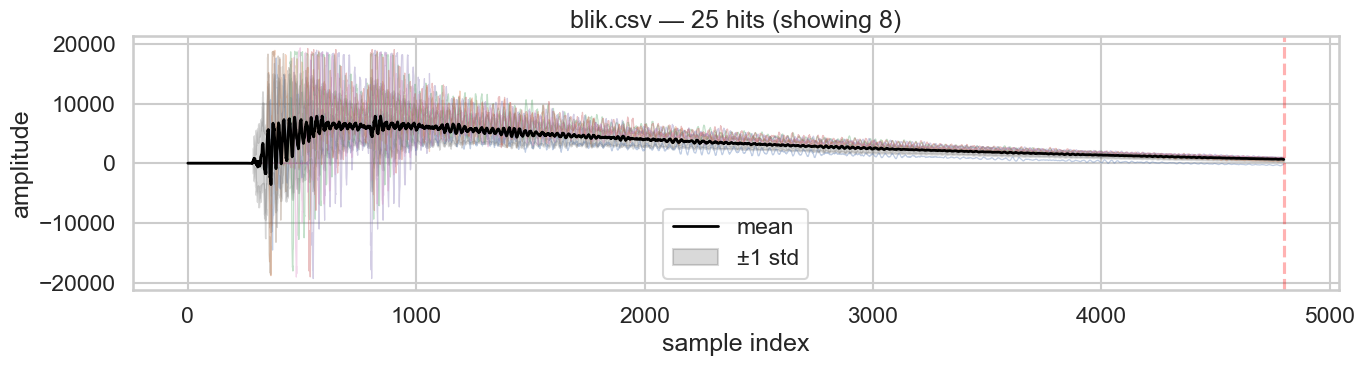

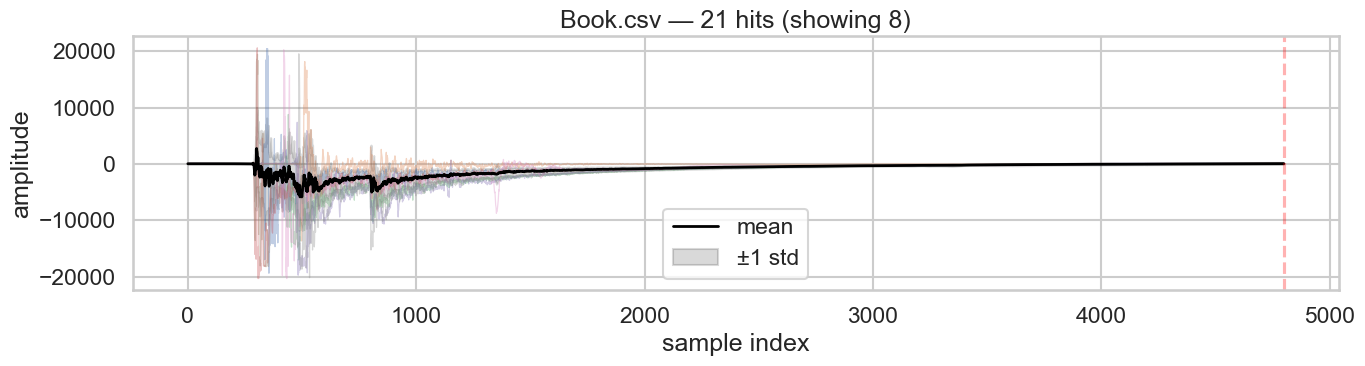

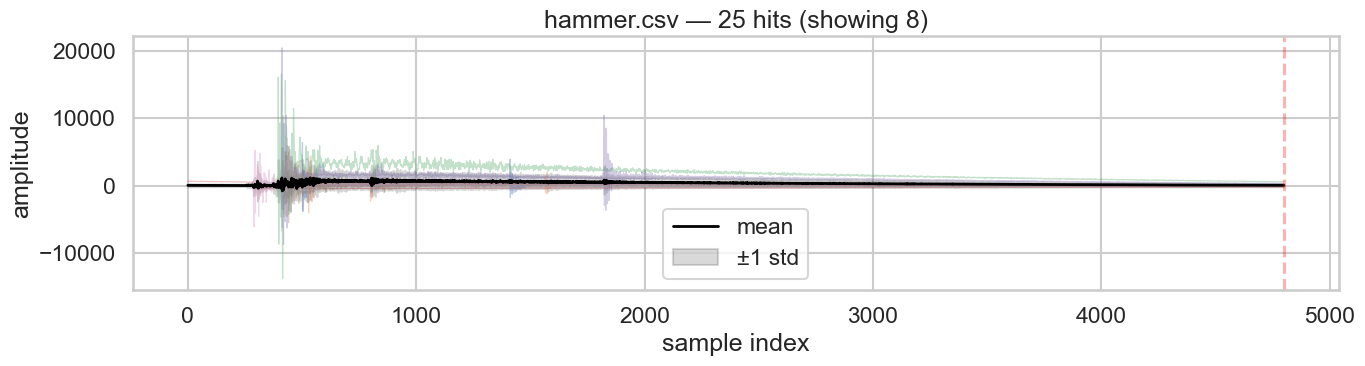

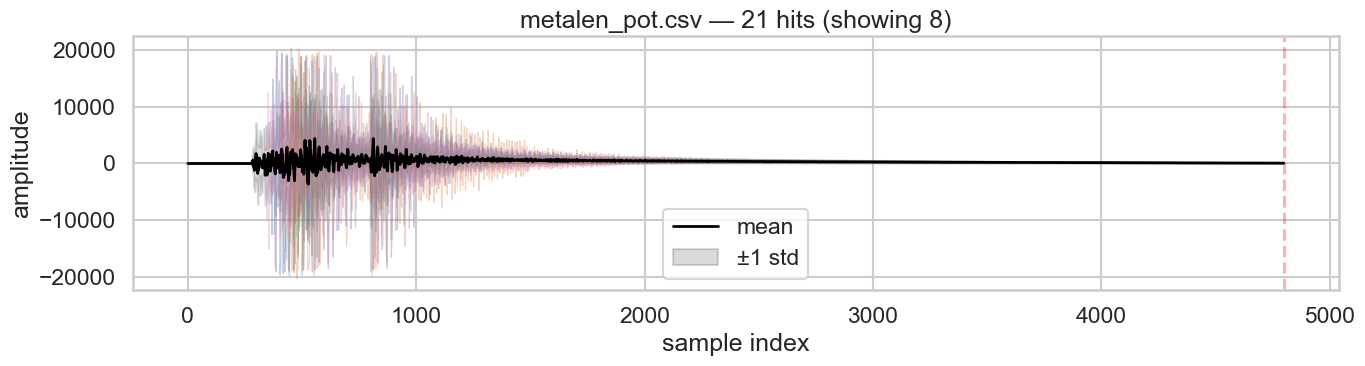

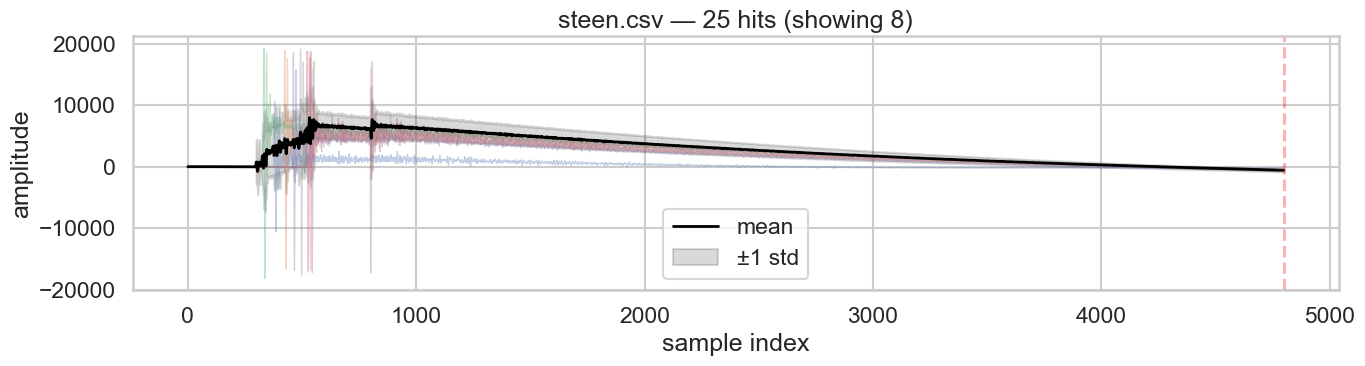

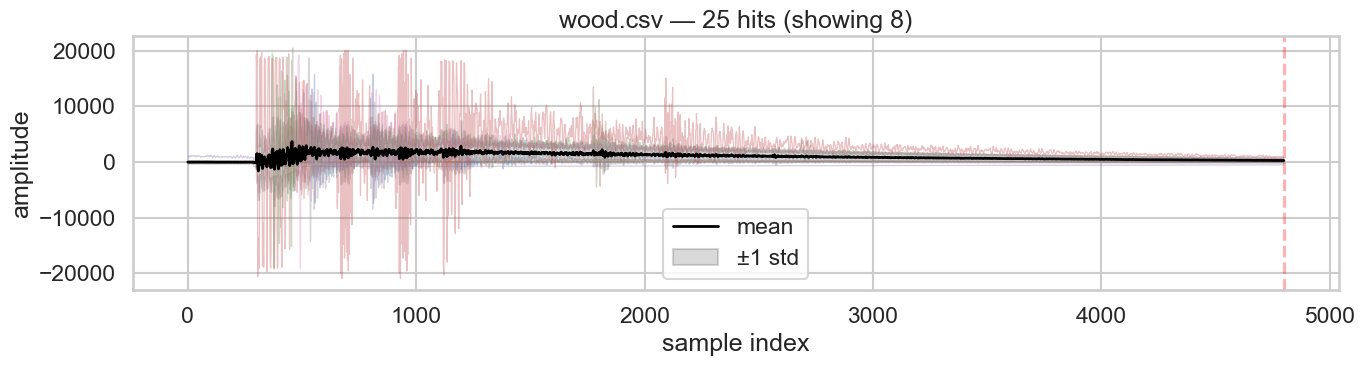

In [7]:
# Waveform plots (overlay first few hits + mean ± std)
sns.set_context('talk')
for name,hits in data.items():
    if hits.ndim == 1:
        hits2 = hits.reshape(1, -1)
    else:
        hits2 = hits
    n_hits, n_samples = hits2.shape
    display_hits = min(8, n_hits)
    plt.figure(figsize=(14,4))
    x = np.arange(n_samples)
    # plot a few individual hits
    for i in range(display_hits):
        plt.plot(x, hits2[i], alpha=0.35, linewidth=0.9)
    # mean and std shading
    mean_wf = hits2.mean(axis=0)
    std_wf = hits2.std(axis=0)
    plt.plot(x, mean_wf, color='black', linewidth=2.0, label='mean')
    plt.fill_between(x, mean_wf-std_wf, mean_wf+std_wf, color='black', alpha=0.15, label='±1 std')
    plt.title(f'{name} — {n_hits} hits (showing {display_hits})')
    plt.xlabel('sample index')
    plt.ylabel('amplitude')
    plt.axvline(expected_len, color='red', linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()


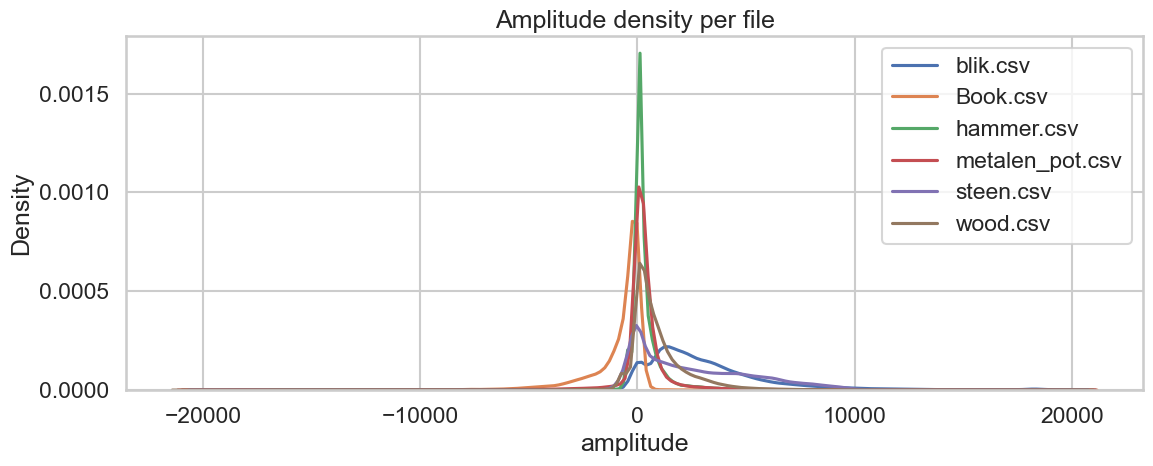

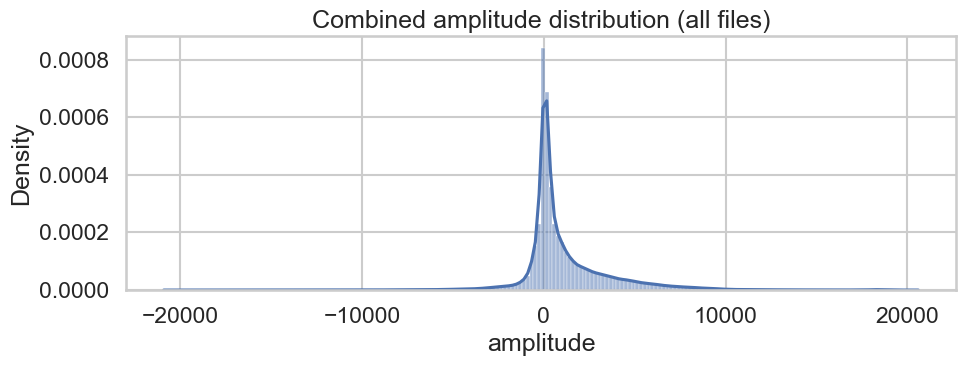

In [8]:
# Amplitude distribution: combined & per-file KDE/hist
plt.figure(figsize=(12,5))
for i,(name,hits) in enumerate(data.items()):
    arr = hits.ravel() if hits.ndim>1 else hits
    sns.kdeplot(arr, label=name, bw_adjust=1.0, clip=(-np.inf, np.inf))
plt.title('Amplitude density per file')
plt.xlabel('amplitude')
plt.legend()
plt.tight_layout()

# Combined histogram with rug
plt.figure(figsize=(10,4))
all_vals = np.hstack([h.ravel() if h.ndim>1 else h for h in data.values()])
sns.histplot(all_vals, bins=200, kde=True, stat='density', color='C0')
plt.title('Combined amplitude distribution (all files)')
plt.xlabel('amplitude')
plt.tight_layout()


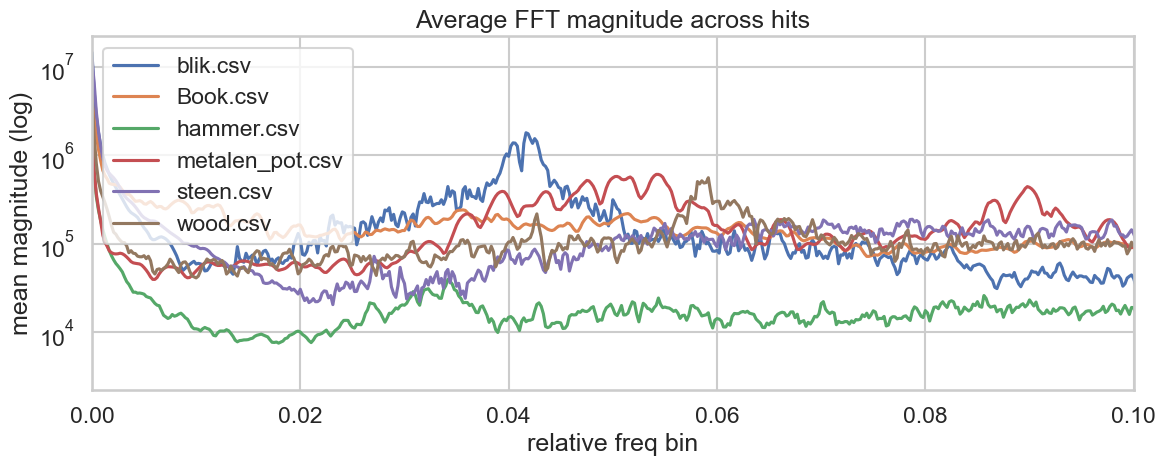

In [9]:
# FFT: average magnitude spectrum across hits (log scale)
plt.figure(figsize=(12,5))
for name,hits in data.items():
    if hits.ndim == 1:
        hits2 = hits.reshape(1,-1)
    else:
        hits2 = hits
    n_hits, n_samples = hits2.shape
    specs = np.abs(np.fft.rfft(hits2, axis=1))
    mean_spec = specs.mean(axis=0)
    freqs = np.fft.rfftfreq(n_samples, d=1.0)
    plt.plot(freqs, mean_spec, label=name)
plt.yscale('log')
plt.xlim(0, freqs.max()*0.2)
plt.xlabel('relative freq bin')
plt.ylabel('mean magnitude (log)')
plt.title('Average FFT magnitude across hits')
plt.legend()
plt.tight_layout()


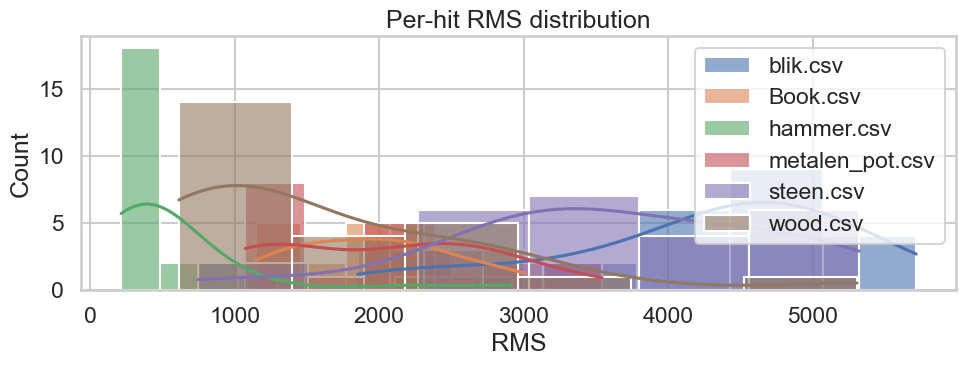

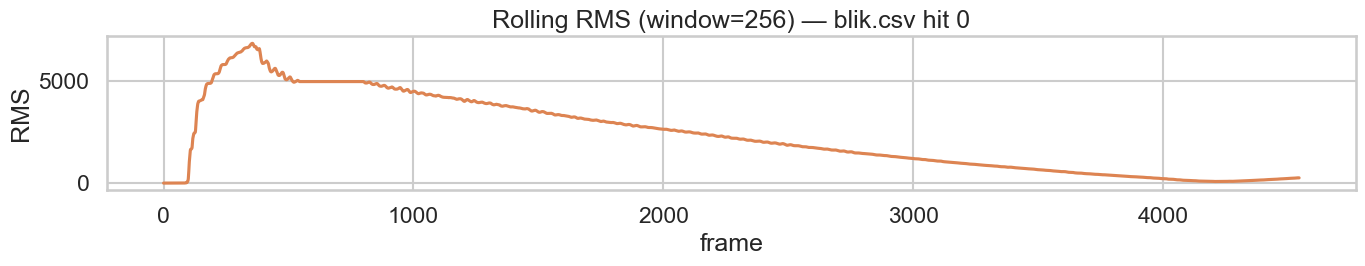

In [10]:
# RMS: per-hit RMS distribution + rolling RMS for example hit
plt.figure(figsize=(10,4))
rms_per_hit = {}
for name,hits in data.items():
    if hits.ndim == 1:
        hits2 = hits.reshape(1,-1)
    else:
        hits2 = hits
    per_hit = np.sqrt(np.mean(hits2**2, axis=1))
    rms_per_hit[name] = per_hit
    sns.histplot(per_hit, kde=True, label=name, alpha=0.6)
plt.title('Per-hit RMS distribution')
plt.xlabel('RMS')
plt.legend()
plt.tight_layout()

# Rolling RMS for first file, first hit
first_name = list(data.keys())[0]
hits = data[first_name]
if hits.ndim == 1:
    sig = hits
else:
    sig = hits[0]

# rolling RMS using numpy (no scipy dependency)
def rolling_rms_vec(sig, window=256):
    if sig.size < window:
        window = max(1, sig.size//10)
    s = np.sqrt(np.convolve(sig**2, np.ones(window)/window, mode='valid'))
    return s

r = rolling_rms_vec(sig, window=256)
plt.figure(figsize=(14,3))
plt.plot(r, color='C1')
plt.title(f'Rolling RMS (window=256) — {first_name} hit 0')
plt.xlabel('frame')
plt.ylabel('RMS')
plt.tight_layout()

In [11]:
# Opslaan van belangrijke plots naar `plots/` map
from pathlib import Path
plots_dir = Path('plots')
plots_dir.mkdir(exist_ok=True)

# 1) Waveform (mean + std) voor elk bestand
for name,hits in data.items():
    if hits.ndim == 1:
        hits2 = hits.reshape(1,-1)
    else:
        hits2 = hits
    n_hits, n_samples = hits2.shape
    x = np.arange(n_samples)
    plt.figure(figsize=(14,4))
    for i in range(min(8, n_hits)):
        plt.plot(x, hits2[i], alpha=0.35, linewidth=0.9)
    mean_wf = hits2.mean(axis=0)
    std_wf = hits2.std(axis=0)
    plt.plot(x, mean_wf, color='black', linewidth=2.0, label='mean')
    plt.fill_between(x, mean_wf-std_wf, mean_wf+std_wf, color='black', alpha=0.15, label='±1 std')
    plt.title(f'{name} — {n_hits} hits (mean ± std)')
    plt.xlabel('sample index')
    plt.ylabel('amplitude')
    plt.legend()
    fn = plots_dir / f"waveform_{name}.png"
    plt.savefig(fn, dpi=150)
    plt.close()

# 2) Amplitude density combined
plt.figure(figsize=(10,5))
for i,(name,hits) in enumerate(data.items()):
    arr = hits.ravel() if hits.ndim>1 else hits
    sns.kdeplot(arr, label=name)
plt.title('Amplitude density per file')
plt.xlabel('amplitude')
plt.legend()
fn = plots_dir / 'amplitude_density.png'
plt.savefig(fn, dpi=150)
plt.close()

# 3) Combined histogram
all_vals = np.hstack([h.ravel() if h.ndim>1 else h for h in data.values()])
plt.figure(figsize=(10,4))
sns.histplot(all_vals, bins=200, kde=True, stat='density', color='C0')
plt.title('Combined amplitude distribution (all files)')
plt.xlabel('amplitude')
fn = plots_dir / 'combined_hist.png'
plt.savefig(fn, dpi=150)
plt.close()

# 4) Average FFT magnitude
plt.figure(figsize=(10,5))
for name,hits in data.items():
    if hits.ndim == 1:
        hits2 = hits.reshape(1,-1)
    else:
        hits2 = hits
    specs = np.abs(np.fft.rfft(hits2, axis=1))
    mean_spec = specs.mean(axis=0)
    freqs = np.fft.rfftfreq(hits2.shape[1], d=1.0)
    plt.plot(freqs, mean_spec, label=name)
plt.yscale('log')
plt.xlim(0, freqs.max()*0.2)
plt.xlabel('relative freq bin')
plt.ylabel('mean magnitude (log)')
plt.title('Average FFT magnitude across hits')
plt.legend()
fn = plots_dir / 'avg_fft.png'
plt.savefig(fn, dpi=150)
plt.close()

# 5) Per-hit RMS distribution
plt.figure(figsize=(10,4))
for name,per_hit in rms_per_hit.items():
    sns.histplot(per_hit, kde=True, label=name, alpha=0.6)
plt.title('Per-hit RMS distribution')
plt.xlabel('RMS')
plt.legend()
fn = plots_dir / 'rms_distribution.png'
plt.savefig(fn, dpi=150)
plt.close()

print('Saved plots to', plots_dir)


Saved plots to plots
